In [1]:
import nltk
nltk.download('punkt')

import re
import pandas as pd

import matplotlib.pyplot as plt
from nltk.corpus import movie_reviews
from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier

import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [3]:
import pandas as pd
df_reviews = pd.read_pickle("udemy_reviews.pkl")
# Aplica pos/neg
df_reviews['tag']=df_reviews['rating'].apply(lambda x: 'pos' if x > 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
df_reviews = df_reviews[df_reviews['comment'].str.contains("\s")]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_reviews = df_reviews[df_reviews['comment'].str.len() >= 12]
#df_reviews = df_reviews.sample(2000)
df_reviews.sample(5)

,id,course,rating,comment,user,tag
24485,88666284,2851496,5.0,Como siempre excelente contenido salu2.,Jhonatan Ortiz Cabezas,pos
12564,11903352,1283984,4.5,"La información que comparte es muy buena para quien no tiene noción de la plataforma. Tengo conocimientos de electrónica y habia escuchado del sistema Arduino, pero no habia interactuado con el. Con este curso, siento que estaré listo para seguir por mi cuenta. En un principio es demasiado básico pero se entiende que es para todos los niveles, solo hay que tener un poco de paciencia.",Nicolas Ramírez,pos
18536,57008576,2831988,5.0,"Excelente curso, muy buen manejo del SQL",Sergio Ricaurte Robles,pos
11499,34010050,101866,5.0,Muy buen curso para aprender lo básico de JS,Jhoan Manuel Ricardo Moreno Sánchez,pos
20483,74941028,2575928,4.5,Enseñas bien pero vas muy rápido.,Jose Danilo Ayala,pos


In [4]:
df = df_reviews[['comment','tag']].rename(columns={'comment': 'review'})
df.head(5)

,review,tag
6545,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,neg
6546,Los conocimientos son claros y concisos para lo requerido,pos
6548,Excelente !!!,pos
6733,Excelente todo!,pos
6734,Explican poco... se lee la mayoría,neg


In [5]:
df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
# separamos entre train y test sets
X = df.review
y = df.tag
X_train_text, X_test_text, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.20, random_state=1234)

# Limpieza del texto
def clean_text(text):
  # En este caso particular no hace falta limpiar los textos
  return text.strip()

def tokenizer(text):
    return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras

In [6]:
len(X_train_text),len(X_test_text)

(125684, 31421)

# Naive Bayes con GridSearch y PreProcesamiento

In [7]:
# Defino el pipeline
pipeline_NB = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, stop_words="english")),
                     ('clf', MultinomialNB())])

parameters_NB = {'tfidf__ngram_range': [(1, 2)],
              'tfidf__min_df': [0.05, 0.1],
              'clf__alpha': [0.01,0.1]}

# Fit and tune model
clf_pipe_feature_sel_NB = GridSearchCV(pipeline_NB, parameters_NB,scoring='f1_macro',cv=5,return_train_score=True, n_jobs=-1)
clf_pipe_feature_sel_NB.fit(X_train_text, y_train);

In [8]:
best_pipeline_feature_sel_NB = clf_pipe_feature_sel_NB.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_NB.best_score_)
print("\nBest parameters set:")
best_parameters_NB = best_pipeline_feature_sel_NB.get_params()
print("tfidf__ngram_range:",best_parameters_NB["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_NB["tfidf__min_df"])
print("clf__alpha:",best_parameters_NB["clf__alpha"])

Best Cross-Validation: 0.49387114715127395

Best parameters set:
tfidf__ngram_range: (1, 2)
tfidf__min_df: 0.05
clf__alpha: 0.1


# Regresión Logística


---




In [9]:
pipeline_log = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, stop_words="english")),
                     ('clf', LogisticRegression(random_state=0, multi_class='ovr'))])

parameters_log = {'tfidf__ngram_range': [(1, 2)],
              'tfidf__min_df': [.05],
              'clf__penalty': ['l1','l2']}

# Fit and tune model
clf_pipe_feature_sel_log = GridSearchCV(pipeline_log, parameters_log,scoring='f1_macro',cv=5,return_train_score=True, n_jobs=-1)
clf_pipe_feature_sel_log.fit(X_train_text, y_train);


C:\Users\Faolin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.58915778]
  warnings.warn(
C:\Users\Faolin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [       nan 0.58960754]
  warnings.warn(


In [10]:
best_pipeline_feature_sel_log = clf_pipe_feature_sel_log.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_log.best_score_)
print("\nBest parameters set:")
best_parameters_log = best_pipeline_feature_sel_log.get_params()
print("tfidf__ngram_range:",best_parameters_log["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_log["tfidf__min_df"])
print("clf__alpha:",best_parameters_log["clf__penalty"])

Best Cross-Validation: 0.5891577776899307

Best parameters set:
tfidf__ngram_range: (1, 2)
tfidf__min_df: 0.05
clf__alpha: l2


# Feature Importance


In [11]:
pipeline_FI = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, 
                                               tokenizer=tokenizer, 
                                               stop_words="english", 
                                               ngram_range = (1,1),
                                               min_df      = best_parameters_log["tfidf__min_df"])),
                     ('clf', LogisticRegression(random_state=0, 
                                                multi_class='ovr',
                                                solver = 'lbfgs',
                                                penalty = best_parameters_log["clf__penalty"]))])

m = pipeline_FI.fit(X_train_text, y_train)

features = m[0].vocabulary_
weights  = m[1].coef_[0]


## Palabras importantes para clasificar reviews Postitivos

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

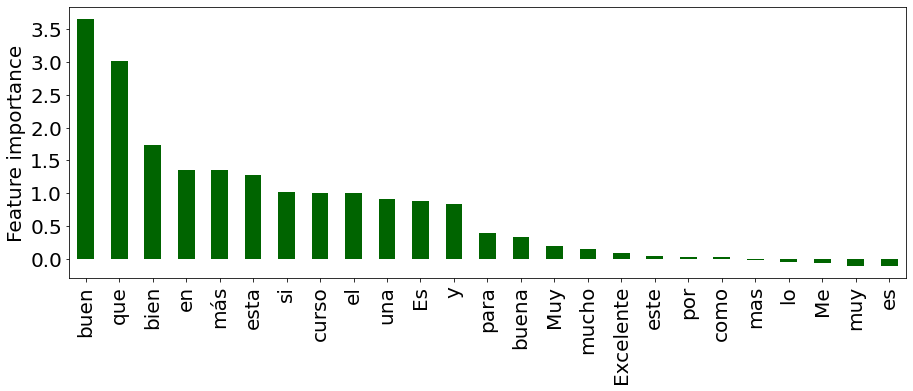

In [12]:
important_Poswords = pd.Series(weights,index=features).sort_values(ascending=False)[:25]
important_Poswords.plot(kind="bar",figsize=(15,5),color="darkgreen")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)

## Palabras importantes para clasificar reviews Negativos

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

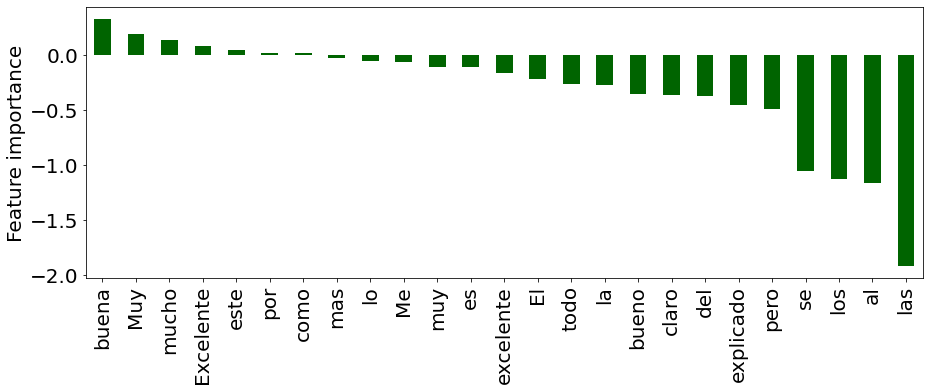

In [13]:
important_Negwords = pd.Series(weights,index=features).sort_values(ascending=False)[-25:]
important_Negwords.plot(kind="bar",figsize=(15,5),color="darkgreen")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)

In [ ]:
pipeline_NN = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, stop_words="english")),
                     ('clf', MLPClassifier())])
parameters_NN = {'tfidf__ngram_range': [(1,2)],
              'tfidf__min_df': [.05],
              'clf__alpha':[1],
              'clf__learning_rate_init': [0.001,0.0001],
              'clf__hidden_layer_sizes': [(100),(1000),(10,10)]}

# Fit and tune model
clf_pipe_feature_sel_NN = GridSearchCV(pipeline_NN, parameters_NN,scoring='f1_macro',cv=5,return_train_score=True, n_jobs=-1)
clf_pipe_feature_sel_NN.fit(X_train_text, y_train);


In [ ]:
best_pipeline_feature_sel_NN = clf_pipe_feature_sel_NN.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_NN.best_score_)
best_parameters_NN = best_pipeline_feature_sel_NN.get_params()
print("tfidf__ngram_range:",best_parameters_NN["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_NN["tfidf__min_df"])
print("clf__alpha:",best_parameters_NN["clf__alpha"])
print("clf__learning_rate_init:",best_parameters_NN["clf__learning_rate_init"])
print("clf__hidden_layer_sizes:",best_parameters_NN["clf__hidden_layer_sizes"])



# Performance en el TestSet

> Indented block



In [ ]:
best_pipeline_feature_sel_NN = clf_pipe_feature_sel_NN.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_NN.best_score_)
best_parameters_NN = best_pipeline_feature_sel_NN.get_params()
print("tfidf__ngram_range:",best_parameters_NN["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_NN["tfidf__min_df"])
print("clf__alpha:",best_parameters_NN["clf__alpha"])
print("clf__learning_rate_init:",best_parameters_NN["clf__learning_rate_init"])
print("clf__hidden_layer_sizes:",best_parameters_NN["clf__hidden_layer_sizes"])



# TF-IDF
### ejemplo

In [ ]:
vectorizer = TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer)

In [ ]:
train_text = ["mono mono cabra",
              "mono mono elefante",
              "mono mono",
              "mono mono mono mono",
              "mono",
              "mono",
              "elefante"]

In [ ]:
tfidf = vectorizer.fit_transform(train_text)

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
tfidf.toarray()

In [ ]:
vectorizer.idf_

In [ ]:
vectorizer.transform(["mono cabra",
                      "mono cabra elefante",
                      "perro mono"]).toarray()